In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from functools import reduce

from scipy.interpolate import griddata
import matplotlib.colors as colors
import time

import numpy as np
import DataPreprocessing
import SmartPolynomials
import SplitDataSet

In [2]:
def transform(me):
    return np.multiply(np.sign(me), np.power(abs(me), 0.5))
def inverse(temp):
    return np.multiply(np.sign(temp), np.power(abs(temp), 1/0.5))
def inverse_tf(temp):
    return tf.multiply(tf.sign(temp), tf.pow(tf.abs(temp), 1/0.5)) 
def frac_error(true, experimental):
    return np.abs(np.divide(inverse(true) - inverse(experimental), inverse(true)))

In [3]:
def perc_error(true, experimental):
    return 100*tf.abs(tf.divide(inverse_tf(true) - inverse_tf(experimental), inverse_tf(true)))

def build_model(components=50, activation='relu'):
    #activation = keras.
    model = keras.Sequential([
        keras.layers.Dense(50, activation='elu', input_shape=[8]), #could try swish??  
        keras.layers.Dense(100, activation='elu'),
        keras.layers.Dense(51, activation='elu'),
        
        keras.layers.Dense(1, activation='linear') 
    ])

    adam = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse', 
                optimizer=adam, metrics=['mape', perc_error])
    return model

In [4]:
def calc_RMSE(mom_train, mom_test, temp_train, temp_test, reuse_model=False):
    if reuse_model:
        model = build_model()
        model.load_weights("NLO/MODEL/uuxg.hdf5")
    else:
        model = build_model()
    
    scaler = StandardScaler()

    poly_train = np.array([np.ndarray.flatten(np.array(element)) for element in mom_train[:,1:]])
    poly_test = np.array([np.ndarray.flatten(np.array(element)) for element in mom_test[:,1:]])
    poly_train = scaler.fit_transform(poly_train) #Rescale on training set
    poly_test = scaler.transform(poly_test)

    # Callback for printing the LR at the end of each epoch.
    class PrintLR(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if epoch % 10 == 0:
                temp_predict = self.model.predict(poly_test)
                temp_predict.shape = (len(temp_predict))
                error = 100*np.mean(born_error(temp_test, temp_predict, temp_test))
                print('\nPercentage error : {}'.format(error))
    
        # Saves the best model's weights
    checkpoint_path = "NLO/MODEL/uuxg.hdf5"
    callback_a = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_best_only=True)
    callback_b = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    tic = time.perf_counter()
    history = model.fit(poly_train, temp_train, batch_size=256, epochs=5000, 
                        shuffle=True, verbose=1, callbacks=[callback_b, callback_a],
                       validation_data=(poly_test, temp_test))
    toc = time.perf_counter()
    print(f"Training ran in {toc - tic:0.4f} seconds")

    try:
        # load the saved model
        saved_model = build_model()
        saved_model.load_weights(checkpoint_path)
        
        train_predict = saved_model.predict(poly_train)
        train_predict.shape = (len(train_predict))     
        train_error = 100*np.mean(frac_error(temp_train, train_predict))                                 
        
        tic = time.perf_counter()
        test_predict = saved_model.predict(poly_test)
        toc = time.perf_counter()
        print(f"Prediction ran in {toc - tic:0.4f} seconds")
        
        test_predict.shape = (len(test_predict))
        test_error = 100*np.mean(frac_error(temp_test, test_predict))

        print('Train: %.3f, Test: %.3f' % (train_error, test_error))
        
        
        np.save('NLO/uuxg/pred_nn.npy', test_predict)
        #return(train_error, test_error, born_error(temp_test, test_predict, rescaled_test[:,0]), history)
        return(train_error, test_error, (temp_test - test_predict)**2, history)
    except ValueError:
        print('Value Error Encountered')       
    return(0, 0, 0, 0)

In [5]:
##Obtain & process data NPY
me_train, mom_train = SplitDataSet.smallestS('NLO/uuxg/me_1000000.npy', 'NLO/uuxg/mom_1000000.npy', 1)
me_test, mom_test = SplitDataSet.smallestS('NLO/uuxg/me_500000.npy', 'NLO/uuxg/mom_500000.npy', 1)

me_swap, mom_swap = SplitDataSet.smallestS('NLO/uuxg/me_1000000.npy', 'NLO/uuxg/mom_1000000.npy', 2)
mom_swap[:,[0,1]] = mom_swap[:,[1,0]]

mom_train = np.concatenate([mom_train, mom_swap],axis=0)
me_train = np.concatenate([me_train, me_swap],axis=0)

me_swap, mom_swap = SplitDataSet.smallestS('NLO/uuxg/me_500000.npy', 'NLO/uuxg/mom_500000.npy', 2)
mom_swap[:,[0,1]] = mom_swap[:,[1,0]]

mom_test = np.concatenate([mom_test, mom_swap],axis=0)
me_test = np.concatenate([me_test, me_swap],axis=0)

Split ran in 2.7913 seconds
Split ran in 1.3017 seconds
Split ran in 2.7786 seconds
Split ran in 1.3278 seconds


In [5]:
me_train, mom_train = SplitDataSet.smallestS('NLO/uuxg/me_1000000.npy', 'NLO/uuxg/mom_1000000.npy', 0)
me_test, mom_test = SplitDataSet.smallestS('NLO/uuxg/me_500000.npy', 'NLO/uuxg/mom_500000.npy', 0)

Split ran in 2.6994 seconds
Split ran in 1.2460 seconds


In [6]:
combs = ['1,3','2,3']

tic = time.perf_counter()
div_train = reduce(np.multiply, DataPreprocessing.mandel_creation(combs, mom_train))
temp_train = np.multiply(div_train[:,np.newaxis], me_train)
toc = time.perf_counter()
print(f"Test multiplication ran in {toc - tic:0.4f} seconds")

tic = time.perf_counter()
div_test = reduce(np.multiply, DataPreprocessing.mandel_creation(combs, mom_test))
temp_test = np.multiply(div_test[:,np.newaxis], me_test)
toc = time.perf_counter()
print(f"Test multiplication ran in {toc - tic:0.4f} seconds")

Test multiplication ran in 0.1372 seconds
Test multiplication ran in 0.0695 seconds


In [7]:
print('Std : {}'.format(np.std(temp_train[:,1])))
print('Mean : {}'.format(np.mean(temp_train[:,1])))

std = np.std(temp_train[:,1])
temp_train = transform(temp_train[:,1]/std)
temp_test = transform(temp_test[:,1]/std)

train, test, perc, history = calc_RMSE(mom_train, mom_test, temp_train, temp_test, reuse_model=False)

Std : 19348.247852645512
Mean : -4951.879064546715
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 666662 samples, validate on 333772 samples
Epoch 1/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 0.0154 - mean_absolute_percentage_error: 18.3905 - perc_error: 34.1688 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 14.9035 - val_perc_error: 30.8441

Epoch 2/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 0.0043 - mean_absolute_percentage_error: 10.5467 - perc_error: 19.7283 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 13.7080 - val_perc_error: 27.9480

Epoch 3/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 0.0029 - mean_absolute_percentage_error: 8.6839 - perc_error: 15.5927 - val_loss: 0.0024 - val_mean_absolute_pe

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 8.6715e-04 - mean_absolute_percentage_error: 3.9107 - perc_error: 7.8823 - val_loss: 7.4165e-04 - val_mean_absolute_percentage_error: 4.1283 - val_perc_error: 7.9589

Epoch 28/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 8.4662e-04 - mean_absolute_percentage_error: 3.7905 - perc_error: 7.7702 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 4.4252 - val_perc_error: 9.4744

Epoch 29/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 8.4211e-04 - mean_absolute_percentage_error: 3.7716 - perc_error: 7.1106 - val_loss: 0.0010 - val_mean_absolute_percentage_error: 3.4027 - val_perc_error: 6.7021

Epoch 30/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 8


Epoch 55/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 6.4661e-04 - mean_absolute_percentage_error: 3.0078 - perc_error: 5.8263 - val_loss: 8.8572e-04 - val_mean_absolute_percentage_error: 2.7899 - val_perc_error: 5.4743

Epoch 56/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 6.5028e-04 - mean_absolute_percentage_error: 2.9967 - perc_error: 6.1594 - val_loss: 7.1974e-04 - val_mean_absolute_percentage_error: 2.5330 - val_perc_error: 4.9409

Epoch 57/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 6.2805e-04 - mean_absolute_percentage_error: 2.9638 - perc_error: 5.6894 - val_loss: 6.5008e-04 - val_mean_absolute_percentage_error: 2.5000 - val_perc_error: 5.2622

Epoch 58/5000
666662/666662 [==============================]666662/666662 [==============================] -

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 5.7190e-04 - mean_absolute_percentage_error: 2.7451 - perc_error: 5.5004 - val_loss: 0.0010 - val_mean_absolute_percentage_error: 4.8658 - val_perc_error: 10.1088

Epoch 83/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 5.4184e-04 - mean_absolute_percentage_error: 2.6963 - perc_error: 5.4949 - val_loss: 3.5802e-04 - val_mean_absolute_percentage_error: 2.6089 - val_perc_error: 5.1468

Epoch 84/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 5.6879e-04 - mean_absolute_percentage_error: 2.7388 - perc_error: 5.5351 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 3.6929 - val_perc_error: 7.5293

Epoch 85/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 


Epoch 110/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 5.5579e-04 - mean_absolute_percentage_error: 2.5512 - perc_error: 4.9748 - val_loss: 4.8412e-04 - val_mean_absolute_percentage_error: 2.2696 - val_perc_error: 4.7418

Epoch 111/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 5.2777e-04 - mean_absolute_percentage_error: 2.5375 - perc_error: 4.7753 - val_loss: 2.9901e-04 - val_mean_absolute_percentage_error: 2.1367 - val_perc_error: 4.1524

Epoch 112/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 5.0008e-04 - mean_absolute_percentage_error: 2.4917 - perc_error: 4.6998 - val_loss: 3.1946e-04 - val_mean_absolute_percentage_error: 2.2422 - val_perc_error: 4.2911

Epoch 113/5000
666662/666662 [==============================]666662/666662 [=============================

666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 4.8819e-04 - mean_absolute_percentage_error: 2.3928 - perc_error: 4.6129 - val_loss: 3.9230e-04 - val_mean_absolute_percentage_error: 2.6466 - val_perc_error: 5.3215

Epoch 138/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 4.6711e-04 - mean_absolute_percentage_error: 2.4038 - perc_error: 4.6718 - val_loss: 5.5092e-04 - val_mean_absolute_percentage_error: 2.4949 - val_perc_error: 5.1120

Epoch 139/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 4.8516e-04 - mean_absolute_percentage_error: 2.4232 - perc_error: 4.6175 - val_loss: 3.5323e-04 - val_mean_absolute_percentage_error: 2.5429 - val_perc_error: 5.2215

Epoch 140/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 4.3982e-04 - mean_absolute_percentage_error: 2.3028 - perc_error: 4.4729 - val_loss: 2.7827e-04 - val_mean_absolute_percentage_error: 2.0509 - val_perc_error: 4.0158

Epoch 165/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 4.4019e-04 - mean_absolute_percentage_error: 2.2783 - perc_error: 4.4654 - val_loss: 2.5797e-04 - val_mean_absolute_percentage_error: 1.8096 - val_perc_error: 3.5490

Epoch 166/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 4.4566e-04 - mean_absolute_percentage_error: 2.2764 - perc_error: 4.3579 - val_loss: 3.2374e-04 - val_mean_absolute_percentage_error: 2.1954 - val_perc_error: 4.3959

Epoch 167/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 4.2929e-04 - mean_absolute_percentage_error: 2.2478 - perc_error: 4.2675 - val_loss: 7.8302e-04 - val_mean_absolute_percentage_error: 3.0236 - val_perc_error: 6.4527

Epoch 192/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 4.1058e-04 - mean_absolute_percentage_error: 2.2165 - perc_error: 4.5862 - val_loss: 2.8714e-04 - val_mean_absolute_percentage_error: 2.0720 - val_perc_error: 4.5738

Epoch 193/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 4.0916e-04 - mean_absolute_percentage_error: 2.2087 - perc_error: 4.3216 - val_loss: 3.1742e-04 - val_mean_absolute_percentage_error: 2.3352 - val_perc_error: 4.7021

Epoch 194/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.9107e-04 - mean_absolute_percentage_error: 2.1266 - perc_error: 4.2786 - val_loss: 0.0010 - val_mean_absolute_percentage_error: 3.3218 - val_perc_error: 7.0236

Epoch 219/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 4.1425e-04 - mean_absolute_percentage_error: 2.1755 - perc_error: 4.1783 - val_loss: 3.3116e-04 - val_mean_absolute_percentage_error: 1.8093 - val_perc_error: 3.4463

Epoch 220/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 4.0628e-04 - mean_absolute_percentage_error: 2.1768 - perc_error: 4.2365 - val_loss: 3.3228e-04 - val_mean_absolute_percentage_error: 1.8039 - val_perc_error: 3.4747

Epoch 221/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - 

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.7513e-04 - mean_absolute_percentage_error: 2.1187 - perc_error: 4.1494 - val_loss: 4.4789e-04 - val_mean_absolute_percentage_error: 2.5979 - val_perc_error: 5.0030

Epoch 246/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 3.7524e-04 - mean_absolute_percentage_error: 2.0866 - perc_error: 4.1340 - val_loss: 3.3526e-04 - val_mean_absolute_percentage_error: 1.9395 - val_perc_error: 3.6816

Epoch 247/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 3.8265e-04 - mean_absolute_percentage_error: 2.0858 - perc_error: 3.9915 - val_loss: 2.9242e-04 - val_mean_absolute_percentage_error: 1.9381 - val_perc_error: 3.9138

Epoch 248/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.7042e-04 - mean_absolute_percentage_error: 2.0676 - perc_error: 4.1959 - val_loss: 3.7732e-04 - val_mean_absolute_percentage_error: 2.1982 - val_perc_error: 4.2198

Epoch 273/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.5503e-04 - mean_absolute_percentage_error: 2.0230 - perc_error: 3.9042 - val_loss: 4.3947e-04 - val_mean_absolute_percentage_error: 2.7692 - val_perc_error: 5.5826

Epoch 274/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 3.6352e-04 - mean_absolute_percentage_error: 2.0557 - perc_error: 4.0733 - val_loss: 2.2857e-04 - val_mean_absolute_percentage_error: 1.7301 - val_perc_error: 3.4012

Epoch 275/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.5508e-04 - mean_absolute_percentage_error: 2.0026 - perc_error: 4.0351 - val_loss: 2.6101e-04 - val_mean_absolute_percentage_error: 1.6919 - val_perc_error: 3.3198

Epoch 300/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.6756e-04 - mean_absolute_percentage_error: 2.0115 - perc_error: 3.9766 - val_loss: 2.7741e-04 - val_mean_absolute_percentage_error: 1.8250 - val_perc_error: 3.4485

Epoch 301/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 3.5430e-04 - mean_absolute_percentage_error: 2.0090 - perc_error: 3.9912 - val_loss: 2.0408e-04 - val_mean_absolute_percentage_error: 1.4975 - val_perc_error: 2.8846

Epoch 302/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 3.3052e-04 - mean_absolute_percentage_error: 1.9469 - perc_error: 3.8245 - val_loss: 2.5633e-04 - val_mean_absolute_percentage_error: 1.8538 - val_perc_error: 3.7276

Epoch 327/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.6038e-04 - mean_absolute_percentage_error: 2.0118 - perc_error: 3.9208 - val_loss: 2.4609e-04 - val_mean_absolute_percentage_error: 1.8057 - val_perc_error: 3.7130

Epoch 328/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.2974e-04 - mean_absolute_percentage_error: 1.9292 - perc_error: 3.6569 - val_loss: 3.5290e-04 - val_mean_absolute_percentage_error: 1.8118 - val_perc_error: 3.3256

Epoch 329/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.3608e-04 - mean_absolute_percentage_error: 1.9578 - perc_error: 4.0383 - val_loss: 2.1522e-04 - val_mean_absolute_percentage_error: 1.9140 - val_perc_error: 3.6962

Epoch 354/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 3.5312e-04 - mean_absolute_percentage_error: 2.0037 - perc_error: 4.1121 - val_loss: 2.4688e-04 - val_mean_absolute_percentage_error: 1.9851 - val_perc_error: 3.8586

Epoch 355/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 3.2159e-04 - mean_absolute_percentage_error: 1.9075 - perc_error: 3.7351 - val_loss: 1.9360e-04 - val_mean_absolute_percentage_error: 1.3645 - val_perc_error: 2.5811

Epoch 356/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 3.4159e-04 - mean_absolute_percentage_error: 1.9589 - perc_error: 3.9036 - val_loss: 2.5139e-04 - val_mean_absolute_percentage_error: 2.0809 - val_perc_error: 4.9097

Epoch 381/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.3511e-04 - mean_absolute_percentage_error: 1.9499 - perc_error: 3.8986 - val_loss: 2.6418e-04 - val_mean_absolute_percentage_error: 1.9809 - val_perc_error: 4.0357

Epoch 382/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.2154e-04 - mean_absolute_percentage_error: 1.8966 - perc_error: 3.7746 - val_loss: 2.3998e-04 - val_mean_absolute_percentage_error: 1.3987 - val_perc_error: 2.6640

Epoch 383/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.1588e-04 - mean_absolute_percentage_error: 1.8871 - perc_error: 3.6815 - val_loss: 2.6579e-04 - val_mean_absolute_percentage_error: 1.6164 - val_perc_error: 3.1578

Epoch 413/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.2200e-04 - mean_absolute_percentage_error: 1.8964 - perc_error: 3.7011 - val_loss: 1.4938e-04 - val_mean_absolute_percentage_error: 1.2997 - val_perc_error: 2.3694

Epoch 414/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.4081e-04 - mean_absolute_percentage_error: 1.9303 - perc_error: 3.6933 - val_loss: 2.4086e-04 - val_mean_absolute_percentage_error: 1.5941 - val_perc_error: 3.0465

Epoch 415/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.0722e-04 - mean_absolute_percentage_error: 1.8319 - perc_error: 3.5631 - val_loss: 2.2739e-04 - val_mean_absolute_percentage_error: 1.7213 - val_perc_error: 3.2273

Epoch 440/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.1737e-04 - mean_absolute_percentage_error: 1.8635 - perc_error: 3.6847 - val_loss: 3.2118e-04 - val_mean_absolute_percentage_error: 1.9743 - val_perc_error: 4.0069

Epoch 441/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.0844e-04 - mean_absolute_percentage_error: 1.8811 - perc_error: 3.6885 - val_loss: 1.8631e-04 - val_mean_absolute_percentage_error: 1.4688 - val_perc_error: 3.0307

Epoch 442/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 3.0837e-04 - mean_absolute_percentage_error: 1.8371 - perc_error: 3.7304 - val_loss: 1.6290e-04 - val_mean_absolute_percentage_error: 1.3773 - val_perc_error: 2.5376

Epoch 467/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.0975e-04 - mean_absolute_percentage_error: 1.8390 - perc_error: 3.6687 - val_loss: 2.8751e-04 - val_mean_absolute_percentage_error: 1.7263 - val_perc_error: 3.3192

Epoch 468/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.7301e-04 - mean_absolute_percentage_error: 1.7587 - perc_error: 3.4920 - val_loss: 2.5163e-04 - val_mean_absolute_percentage_error: 1.7469 - val_perc_error: 3.5465

Epoch 469/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/ste

666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 2.9262e-04 - mean_absolute_percentage_error: 1.7901 - perc_error: 3.6231 - val_loss: 3.2453e-04 - val_mean_absolute_percentage_error: 2.0041 - val_perc_error: 3.8158

Epoch 494/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.7750e-04 - mean_absolute_percentage_error: 1.7772 - perc_error: 3.5380 - val_loss: 1.3910e-04 - val_mean_absolute_percentage_error: 1.2531 - val_perc_error: 2.2639

Epoch 495/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 3.0507e-04 - mean_absolute_percentage_error: 1.8049 - perc_error: 3.4455 - val_loss: 2.2740e-04 - val_mean_absolute_percentage_error: 1.5161 - val_perc_error: 2.8514

Epoch 496/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.8099e-04 - mean_absolute_percentage_error: 1.7404 - perc_error: 3.3043 - val_loss: 2.9360e-04 - val_mean_absolute_percentage_error: 1.8073 - val_perc_error: 3.4569

Epoch 521/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 2.9752e-04 - mean_absolute_percentage_error: 1.7708 - perc_error: 3.4686 - val_loss: 4.8158e-04 - val_mean_absolute_percentage_error: 1.5295 - val_perc_error: 2.9249

Epoch 522/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 3.0164e-04 - mean_absolute_percentage_error: 1.8215 - perc_error: 3.5586 - val_loss: 2.0880e-04 - val_mean_absolute_percentage_error: 1.3740 - val_perc_error: 2.5872

Epoch 523/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 2.8434e-04 - mean_absolute_percentage_error: 1.7296 - perc_error: 3.3760 - val_loss: 2.2071e-04 - val_mean_absolute_percentage_error: 1.3194 - val_perc_error: 2.4901

Epoch 548/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.9825e-04 - mean_absolute_percentage_error: 1.7773 - perc_error: 3.4134 - val_loss: 1.4965e-04 - val_mean_absolute_percentage_error: 1.2372 - val_perc_error: 2.2526

Epoch 549/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.7486e-04 - mean_absolute_percentage_error: 1.7075 - perc_error: 3.4132 - val_loss: 3.6684e-04 - val_mean_absolute_percentage_error: 2.0892 - val_perc_error: 3.9488

Epoch 550/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.8513e-04 - mean_absolute_percentage_error: 1.7550 - perc_error: 3.3556 - val_loss: 2.2914e-04 - val_mean_absolute_percentage_error: 1.5240 - val_perc_error: 2.9971

Epoch 575/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.7556e-04 - mean_absolute_percentage_error: 1.7085 - perc_error: 3.2726 - val_loss: 1.6123e-04 - val_mean_absolute_percentage_error: 1.2241 - val_perc_error: 2.1994

Epoch 576/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.8099e-04 - mean_absolute_percentage_error: 1.7331 - perc_error: 3.2517 - val_loss: 2.6873e-04 - val_mean_absolute_percentage_error: 2.0689 - val_perc_error: 4.0187

Epoch 577/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.8983e-04 - mean_absolute_percentage_error: 1.7835 - perc_error: 3.4898 - val_loss: 4.0413e-04 - val_mean_absolute_percentage_error: 1.7212 - val_perc_error: 3.3559

Epoch 602/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 3.0179e-04 - mean_absolute_percentage_error: 1.7830 - perc_error: 3.5623 - val_loss: 3.2105e-04 - val_mean_absolute_percentage_error: 1.6802 - val_perc_error: 3.2294

Epoch 603/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 2.6612e-04 - mean_absolute_percentage_error: 1.7108 - perc_error: 3.5085 - val_loss: 3.6585e-04 - val_mean_absolute_percentage_error: 1.6810 - val_perc_error: 3.1642

Epoch 604/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 2.7666e-04 - mean_absolute_percentage_error: 1.7146 - perc_error: 3.2178 - val_loss: 2.0715e-04 - val_mean_absolute_percentage_error: 1.3738 - val_perc_error: 2.5254

Epoch 629/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 2.7871e-04 - mean_absolute_percentage_error: 1.7481 - perc_error: 3.3697 - val_loss: 1.7352e-04 - val_mean_absolute_percentage_error: 1.3644 - val_perc_error: 2.5284

Epoch 630/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.5556e-04 - mean_absolute_percentage_error: 1.6271 - perc_error: 3.1700 - val_loss: 1.4174e-04 - val_mean_absolute_percentage_error: 1.2900 - val_perc_error: 2.4203

Epoch 631/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 2.7824e-04 - mean_absolute_percentage_error: 1.7231 - perc_error: 3.4272 - val_loss: 2.6300e-04 - val_mean_absolute_percentage_error: 1.9748 - val_perc_error: 3.8436

Epoch 656/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 2.6599e-04 - mean_absolute_percentage_error: 1.6749 - perc_error: 3.2669 - val_loss: 1.3288e-04 - val_mean_absolute_percentage_error: 1.3271 - val_perc_error: 2.3991

Epoch 657/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.6044e-04 - mean_absolute_percentage_error: 1.6860 - perc_error: 3.2786 - val_loss: 1.1411e-04 - val_mean_absolute_percentage_error: 1.1088 - val_perc_error: 1.9858

Epoch 658/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.6638e-04 - mean_absolute_percentage_error: 1.6597 - perc_error: 3.2834 - val_loss: 3.6379e-04 - val_mean_absolute_percentage_error: 3.4747 - val_perc_error: 7.1964

Epoch 683/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.7667e-04 - mean_absolute_percentage_error: 1.7276 - perc_error: 3.3350 - val_loss: 2.2141e-04 - val_mean_absolute_percentage_error: 1.6449 - val_perc_error: 3.1378

Epoch 684/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.5685e-04 - mean_absolute_percentage_error: 1.6675 - perc_error: 3.2433 - val_loss: 3.2617e-04 - val_mean_absolute_percentage_error: 1.7670 - val_perc_error: 3.3638

Epoch 685/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 14us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.6796e-04 - mean_absolute_percentage_error: 1.6692 - perc_error: 3.1910 - val_loss: 2.2330e-04 - val_mean_absolute_percentage_error: 1.6011 - val_perc_error: 3.0286

Epoch 710/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 13us/step - loss: 2.5572e-04 - mean_absolute_percentage_error: 1.6258 - perc_error: 3.3473 - val_loss: 5.0396e-04 - val_mean_absolute_percentage_error: 1.6457 - val_perc_error: 3.2410

Epoch 711/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 2.7673e-04 - mean_absolute_percentage_error: 1.6900 - perc_error: 3.2081 - val_loss: 3.3154e-04 - val_mean_absolute_percentage_error: 2.3827 - val_perc_error: 5.1003

Epoch 712/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.5146e-04 - mean_absolute_percentage_error: 1.6135 - perc_error: 3.1132 - val_loss: 1.9671e-04 - val_mean_absolute_percentage_error: 1.4081 - val_perc_error: 2.6860

Epoch 737/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.4922e-04 - mean_absolute_percentage_error: 1.6048 - perc_error: 3.0833 - val_loss: 2.6816e-04 - val_mean_absolute_percentage_error: 1.9520 - val_perc_error: 3.8388

Epoch 738/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.6560e-04 - mean_absolute_percentage_error: 1.6447 - perc_error: 3.1547 - val_loss: 1.7154e-04 - val_mean_absolute_percentage_error: 1.3919 - val_perc_error: 2.6350

Epoch 739/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.4928e-04 - mean_absolute_percentage_error: 1.6255 - perc_error: 3.0919 - val_loss: 1.6321e-04 - val_mean_absolute_percentage_error: 1.3159 - val_perc_error: 2.4352

Epoch 764/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/step - loss: 2.5765e-04 - mean_absolute_percentage_error: 1.6377 - perc_error: 3.1018 - val_loss: 2.1729e-04 - val_mean_absolute_percentage_error: 1.6765 - val_perc_error: 3.1498

Epoch 765/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.5574e-04 - mean_absolute_percentage_error: 1.6034 - perc_error: 3.1396 - val_loss: 1.8053e-04 - val_mean_absolute_percentage_error: 1.6115 - val_perc_error: 3.0973

Epoch 766/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/ste

666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.5572e-04 - mean_absolute_percentage_error: 1.6137 - perc_error: 3.0503 - val_loss: 2.1059e-04 - val_mean_absolute_percentage_error: 1.4872 - val_perc_error: 2.8538

Epoch 791/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.5600e-04 - mean_absolute_percentage_error: 1.6476 - perc_error: 3.1261 - val_loss: 1.8845e-04 - val_mean_absolute_percentage_error: 1.2753 - val_perc_error: 2.3684

Epoch 792/5000
666662/666662 [==============================]666662/666662 [==============================] - 8s 12us/step - loss: 2.4352e-04 - mean_absolute_percentage_error: 1.5814 - perc_error: 2.9967 - val_loss: 2.2577e-04 - val_mean_absolute_percentage_error: 1.1830 - val_perc_error: 2.1839

Epoch 793/5000
666662/666662 [==============================]666662/666662 [==============================] - 9s 13us/ste

In [23]:
print(sum([1 for x in me_test[:,1] if x < 0]))
print(np.argmin(me_test[:,1]))
print(me_test[249761])
print(min(np.array([x + y for x, y in me_test[:,[0,1]]])))

141081
249761
[ 0.80199089 -4.16638045 -0.62646894 -0.06295224]
-3.364389557577856


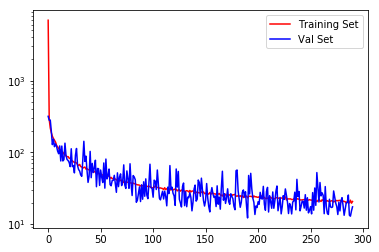

In [6]:
points = len(history.history['loss'])
pyplot.plot(range(points), history.history['loss'], color='r', label='Training Set')
pyplot.plot(range(points), history.history['val_loss'],color='b', label='Val Set')
pyplot.legend()
#pyplot.ylim(0, 18)
pyplot.yscale('log')

2 Layers 500 components min ~ 0.05 mse and 10% error.
Reduced layers by 1 and added 500 components. 

In [7]:
print(train)
print(test)
print(100*np.mean(perc))

2.0909617689350886
1.9846250588931518
1.9846250588931518


In [8]:
saved_model = build_model()
saved_model.load_weights("NLO/MODEL/uuxg.hdf5")


tic = time.perf_counter()
test_predict = saved_model.predict(poly_test)
toc = time.perf_counter()
print(f"Prediction ran in {toc - tic:0.4f} seconds")


NameError: name 'poly_test' is not defined

###### print(me_predict)

###### 60% error for temp
Scaled by log 0.04469647411690197

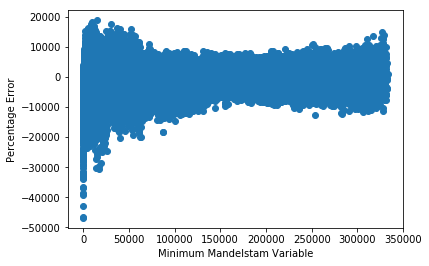

In [12]:
mandel_str = ['1,3','2,3','1,2']
def error_smallest_S(perc_error, mom):
    mandel_vars = DataPreprocessing.mandel_creation(mandel_str, mom)
    min_mandel_vars = [min(mandel_var) for mandel_var in mandel_vars.T]
    #print(sum([1 for i, mandel_var in enumerate(min_mandel_vars) if mandel_var > 175000]))
    #print(100*np.mean([perc_error[i] for i, mandel_var in enumerate(min_mandel_vars) if mandel_var > 100]))
    pyplot.scatter(min_mandel_vars,perc_error)
    pyplot.xlabel('Minimum Mandelstam Variable')
    pyplot.ylabel('Percentage Error')
    #pyplot.xlim(0,1000000)
    
error_smallest_S(perc, mom_test)

In [8]:
s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','1,3','2,3'], mom_test)

x1 = np.divide(s12, 1000000)
x2 = np.divide(s13, 1000000)
x3 = np.divide(s23, 1000000)

x2i = np.linspace(0, 1, 500) #x1 coordinates
x3i = np.linspace(0, 1, 500) #x2 coordinates
X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.

In [9]:
#Value at grid coordinate is mapped to the nearest actual datapoint.
print(len(perc))
grid = griddata((x2, x3), np.abs(perc), (X2i, X3i), method='linear')
print(grid)

332820
[[          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan 3904.95046519           nan ...           nan
            nan           nan]
 ...
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]]


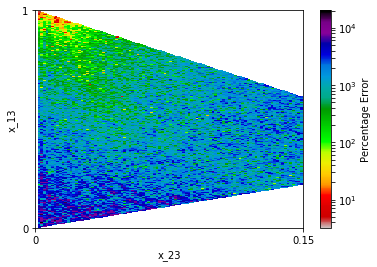

In [10]:
fig, ax = pyplot.subplots()
im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
cbar = ax.figure.colorbar(im)
cbar.set_label('Percentage Error')

ax.set_xticks([0, 100])
ax.set_xticklabels([0, 0.15])
ax.set_xlim(0,100)
ax.set_yticks([0, 500])
ax.set_yticklabels([0, 1])


ax.set_ylabel('x_13')
ax.set_xlabel('x_23')

pyplot.savefig('PercentageError.png')